# Markov chains and stochastic recurrence relations

Some recurrant dynamic systems are naturally *stochastic* (or - in other words - involve a bit of randomness).  In this post - continuing our discussion of [recurrence relations](https://blog.dgsix.com/posts/recurrence_relations/recurrence_relations.html) - we introduce the basic version of such a model via its most popular application - as a model of written text.  This kind of dynamic system is often referred to as a *Markov Chain*.

You can skip around this document to particular subsections via the hyperlinks below.

-  [Natural ordering in text](#text-natural-order)
-  [Stochastic choices, histograms, and Markov chains](#stochastic-choices)
-  [Markov chains on the character-level](#character-level)
-  [The mathematics of a Markov chain](#modeling)
-  [Examples and `Python` implementation](#code)
-  [Fixed order and limited memory](#limited-memory)
-  [Markov chains with one-hot encoded vectors](#one-hot)
-  [Markov chains with unlimited memory](#unlimited)

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library for animations
from library import word_level_markov_model
from library import markov_words_demo
from library import markov_chars_demo
from library import text_parsing_utils

# import standard libs
import numpy as np
import pandas as pd

# path to data
datapath = '../../datasets/markov_chains/'

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

<a id='text-natural-order'></a>
## Natural ordering in text

Below we animate a simple sentence "my dog runs".  Each *word* in this sentence does - intuitively - seem to follow its predecessor in an natural, orderly, and predictable way.  In the animation we walk through the sentence word-by-word, highlighting the fact that each word follows its immediate predecessor. 

<figure>
<p>
<img src= 'images/dog1.gif' width="50%" height="50%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> Each word in a simple English sentence follows its predecessor in an natural, orderly, and predictive fashion.
</em>
</figcaption>
</figure>

This kind natural ordering holds with text more generally as well, and (in the context of dynamic systems) provokes a natural question: can text be modeled as a *recurrence relation*?  As [discussed in a previous post](https://blog.dgsix.com/posts/recurrence_relations/recurrence_relations.html), limited memory recurrence relations take in a window of $D$ elements of an input sequence $x_{p-1},x_{p-2},...,x_{p-D}$ and generate the next element (here a word) $x_p$ as


\begin{equation}
x_{p} = f\left(x_{p-1},x_{p-2},...,x_{p-D}\right).
\end{equation}

If this were possible we would of course need to define an appropriate value for $D$ as well as an appropriate form for the function $f$.  But more fundamentally, while text certainly seems to have the structure of a recurrence relation (with words in a sentence being reasonably predicted by its predecessors), text does have one attribute that we have not seen thus far: *choice*.  That is, a word or set of words does not often uniquely determine the word that follows it.   

For example, in the sentence above we could imagine a range of words following the word "dog" instead of "runs", like e.g., "eats".  This would give us the sentence "my dog eats" instead of "my dog runs", which is a perfectly valid and meaningful English sentence.  Of course there are other words that could follow "dog" as well, some of which like e.g., the word "sighs" that while valid would be less common than "eats".  However some words, like e.g., "dracula", making the sentence "my dog dracula" do not make any sense at all.  Thus with text while we do have *choices* for each follow-up word, some choices are more likely to occur than others.  These choices are *stochastic* in nature - meaning each arises with a different *probability* of occurrence.

<figure>
<p>
<img src= 'images/dog2.gif' width="50%" height="50%" alt=""/>
</p>
<figcaption> <strong>Figure 2:</strong> <em> Many words could potentially follow the word "dog" in this sentence.  However some words - like "runs" or "eats" - are far more likely than others like "sighs".  Further, some words like e.g., "dracula" do not make any sense.
</em>
</figcaption>
</figure>

<a id='stochastic-choices'></a>
## Stochastic choices, histograms, and Markov chains

To illustrate this point, below we show the four choices of words following "dog" in the animation shown above assigning a probability of occurrence to each.  We made up for these probabilities for this simple example as well as the examples that follow, but in practice these can be computed *empirically*.  More specifically this can be done by taking a large body of text (like e.g., a long book), scanning it for all occurrences of each of its words, and for each forming a normalized histogram of probabilities of its follow-up words.  In any case, here we suppose the word "runs" is the most probable, "eats" the next, and so on.  The probabilities shown do not add up to $1$ because there could be other reasonable words that could follow "dog" other than those shown here (like "barks", for example).  

This set of words following "dog", along with their respective probabilities of occurrence (that is, the probability that they occur following the word "dog"), can be nicely represented as a *normalized histogram* (also known as a discrete probability distribution) as shown in the right panel below.  This normalized histogram visualizes the probability of each follow-up word as a vertical bar whose height is proportional to a word's probability of occurrence in following the word "dog".

<figure>
<p>
<img src= 'images/dog_with_hist.png' width="80%" height="60%" alt=""/>
</p>
<figcaption> <strong>Figure 3:</strong> <em> (left panel) Here we show a selection of words that could possibly follow the word "dog", along with a probability of the word occurring (which here we assign ourselves via our intuition).  In this case the word "runs" has the highest probability of occurring after "dog", then "eats", and so on.  The probabilities do not add up to $1$ because there are other words that could reasonably follow "dog" that we do not list here. (right panel) The set of possible words following the word "dog" shown in the left viewed as a *histogram*, where the height of each bar is proportional to each following word's probability of occurrence.
</em>
</figcaption>
</figure>

Notice that while many words *can* follow the word "dog", if we had to make a single *educated guess* as to the next best word to follow-up the word "dog" based on this discrete probability distribution we would choose the highest probably follow-up word "run".  This sort of model for text, from the capturing of its stochastic nature of follow-up words via a discrete probability distribution to the probability-maximizing "educated guess" for the next best word, is called a *stochastic recurrence relation* or (more popularly) a *Markov chain*.

Notice that we can also think of each word in a sentence following logically based not just on its immediate predecessor, but on several words (in other words, we can use a larger window).  Text certainly is generally structured like this - with preceding words in a sentence generally determining those that follow.   In the Figure below we show an illustration that mirrors that of Figure 3 above using a window size (or *order*) $D = 2$.  Now the probabilities of occurrence for each follow-up word reflects how frequently each word follows the phrase "my dog".  Once again if we wanted to make an educated guess - based on this discrete probability - of what word likely follows the phrase "my dog" we would choose the most probable follow-up word "sleeps".

<figure>
<p>
<img src= 'images/order_2.png' width="80%" height="80%" alt=""/>
</p>
<figcaption> <strong>Figure 4:</strong> <em> An illustration mirroring Figure 3 above using a window size (or *order*) of $D = 2$.  Here we look at the statistics of follow-up words for the phrase "my dog" precisely as we did in the order $D = 1$ case - by forming a normalized histogram / discrete probability distribution over all the words following them.  
</em>
</figcaption>
</figure>

Notice as we increase the number of words, or likewise our window size $D$, that it gets easier and easier to make an "educated guess" as to the correct follow-up word *using our probability-maximizing choice*.  This is because the phrase in our length $D$ window becomes more and more unique with each added word, and eventually only a single follow-up word will ever follow it, and the distribution of follow-up words collapses to an *impulse* or [dirac delta](https://en.wikipedia.org/wiki/Dirac_delta_function) function.  This means that once the window becomes large enough our probability-maximizing follow-up word model indeed defines a perfect recurrence relation, 

We illustrate this idea with a longer (and more popular) phrase below: "a rose by any other name would smell as ".  This popular Shakespearean phrase has only a single possible follow-up word: "sweet".  

<figure>
<p>
<img src= 'images/order_D.png' width="80%" height="80%" alt=""/>
</p>
<figcaption> <strong>Figure 5:</strong> <em> As the window length $D$ is increased the phrase in our window becomes more and more unique, with the distribution of follow-up words collapsing to a unit impulse (meaning only one kind of follow-up word ever follows our input phrase).    
</em>
</figcaption>
</figure>

<a id='character-level'></a>
## Markov chains on the character-level

The same thought process leading to the word-by-word model of text detailed above also leads to a similar idea: modeling text *character-by-character*.  All of the same logic developed for the word-wise model applies here as well.  If we examine a string of English text - on the level of characters this time - once again upon reflection we see a natural ordering to the characters (as in the example shown in the Figure below).  Some characters - as with words - seem to naturally follow others.  Of course just as with words, the issue here is once again at each step we have *stochasticity* or multiple choices for what the next character should be.  In other words, we have a histogram / discrete probability distribution over the full set of possible English characters that reflects the likelihood of each character occurring (with respect to a large corpus on which we build such histograms).  As we increase the order of our model - just as in the word-wise case - our generated text looks more and more like the corpus on which we compute our histograms.

<figure>
<p>
<img src= 'images/chars.png' width="70%" height="70%" alt=""/>
</p>
<figcaption> <strong>Figure 5:</strong> <em> 
Illustrations of the concepts described in the prior three Figures, only here for modeling text as a stochastic recurrence relation *character-wise* instead of word-wise.  In each case to make a reasonable prediction about the next character we form a normalized histogram / discrete probability distribution over all the characters that follow each input character(s).  Note in the window size $D = 2$ case shown here the empty circle contains the 'space' character.  As we increase the window size here - just as with the word-wise model detailed above - our generated sequence will start to look more and more like the text on which we computed our histograms.
</em>
</figcaption>
</figure>

<a id='modeling'></a>
## The mathematics of a Markov chain

Let us mathematically codify the Markov model - using words as our fundamental unit and beginning with the first simple word-wise example illustrated in Figure 3 as a jumping off point.  Note however that everything we discuss here generalizes to all word-level and character-level modeling as well.

As shown in Figure 3 above we form a histogram of follow-up words to the input word "dog", along with their probability of occurrence.  A normalized histogram is just *vector-valued* output representing the occurrence probability of each possible follow-up word to our input.  For example, we can formally jot down the histogram of possible outputs of words following "dog" as

\begin{equation}
\text{histogram}\left(\text{"dog"}\right) = 
\begin{cases}
\text{"runs"} \,\,\,\,\,\,\,\,\,\,\,\, \text{with probability} \,\,\,\mathscr{y} = 0.4 \\
\text{"eats"} \,\,\,\,\,\,\,\,\,\,\,\,\, \text{with probability} \,\,\,\mathscr{y} = 0.3 \\
\text{"sighs"} \,\,\,\,\,\,\,\,\,\, \text{with probability} \,\,\,\mathscr{y} = 0.05 \\
\text{"dracula"} \,\,\,\,\, \text{with probability} \,\,\,\mathscr{y}= 0 \\
\,\,\,\,\,\, \vdots
\end{cases}
\end{equation}

Here in each case $\mathscr{y}$ stands for the *probability* of the corresponding follow-up word occurring.  As mentioned previously, the best follow-up word based on this histogram is simply the one with the *maximum probability* of occurrence.  Here suppose that word is "runs".  Translating this statement into math, we predict the word following "dog" by taking the $\text{argmax}$ over all of the choices above as

\begin{equation}
\text{(word we predict to follow "dog")} \,\,\,\,\, \text{"runs"} = \underset{\mathscr{y}}{\text{argmax}}\,\,\,\, \text{historgram}\left(\text{"dog"}\right).
\end{equation}

More generally, if we denote by $x_{p-1}$ the $\left(p-1\right)^{th}$ word in a sentence, then the choice of the next word $h_{p}$ can likewise be written in general as

\begin{equation}
h_{p} = \underset{\mathscr{y}}{\text{argmax}}\,\, \text{histogram}\left(x_{p-1}\right).
\end{equation}

Denoting by $f\left(x_{p-1}\right) = \underset{\mathscr{y}}{\text{argmax}}\,\, \text{histogram}\left(x_{p-1}\right)$ we can express our Markov chain model as a [dynamic system with limited memory](https://blog.dgsix.com/posts/dynamic_systems_limited_memory/dynamic_systems_limited_memory.html) as

\begin{equation}
h_{p} = f\left(x_{p-1}\right).
\end{equation}

Using the same function $f$ we general order $D$ Markov model via the general update step

\begin{equation}
h_{p} = f\left(x_{p-1},...,x_{p - D}\right)
\end{equation}

only here our $\text{histogram}$ function computes the histogram of follow-up words of the input sequence $x_{p-1},...,x_{p - D}$.  



Finally - as mentioned above - when $D$ is large enough this model becomes a perfect [recurrence relation](https://blog.dgsix.com/posts/recurrence_relations/recurrence_relations.html), since as $D$ increases the number of possible follow-up words narrows more and more, eventually diminishing to a single word.  Thus the formula above reduces to

\begin{equation}
x_{p} = f\left(x_{p-1},...,x_{p - D}\right)
\end{equation}

since indeed the output of $f$ is the next actual word $x_p$.

<a id='code'></a>
## Examples and `Python` implementation

#### <span style="color:#a50e3e;">Example 1. </span>  Generating text word-by-word via a Markov chain

In this example we generate a Markov chain model of text using the classic novel *War of the Worlds* by H.G. Wells to define our transition probabilities (the text of which can be found legally for free online [e.g., here](https://archive.org/stream/TheWarOfTheWorlds-H.G.Wells/war-worlds_djvu.txt)).  Below we print out the first $500$ characters of the novel.  Note some pre-processing has been done here - in particular we removed any strange characters introduced when converting this book to its e-version, and lower-case-afied all alphabetical characters.

In [8]:
csvname = datapath + "war_of_the_worlds.txt"
model = word_level_markov_model.Markov(csvname)
model.text[:500]

"the war of the worlds  by h. g. wells   but who shall dwell in these worlds if they be  inhabited? are we or they lords of the  world? and how are all things made for man?    kepler (quoted in the anatomy of melancholy)  book one  the coming of the martians  chapter one  the eve of the war no one would have believed in the last years of the nineteenth century that this world was being watched keenly and closely by intelligences greater than man's and yet as mortal as his own; that as men busied "

The `Python` function used to pre-process the text is shown below - and requires minimal functionality.

In [ ]:
## load and preprocess text ##
def load_preprocess(csvname):
    # load in text dataset - lower case all
    text = open(csvname).read().lower()
    
    # cut out first chunk of giberish text - for this text non-giberish began at the 948th character
    text = text[947:]

    # remove some obvious tag-related gibberish throughout
    characters_to_remove = ['0','1','2','3','4','5','6','7','8','9','_','[',']','}','.  .  .','\\']
    for i in characters_to_remove:
        text = text.replace(i,'')

    # some gibberish that looks like it needs to be replaced with a ' '
    text = text.replace('\n',' ')
    text = text.replace('\r',' ')
    text = text.replace('--',' ')
    text = text.replace(',,',' ')
    text = text.replace('   ',' ')
    
    return text

To produce an order $D$ Markov model we then run through the text and  compute our discrete transiition probabilities.  To do this we first produce a dictionary `words_to_keys` that maps each word (also called a "token") to a discrete integer (called a "key"), and another dictionary `keys_to_words` for the reverse mapping (from keys back to words).  These dictionaries are computed via the `parse_words` function below - and employs a simple function called `CountVectorizer` from `sklearn`.

In [ ]:
# imports
from sklearn.feature_extraction.text import CountVectorizer

## parse a text into words - producing mapping dictionaries ##
def parse_words(text):
    # load in function from scikit learn that 
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([text])
    analyze = vectorizer.build_analyzer()

    # get all unique words in input corpus
    tokens = analyze(text)
    unique_words = vectorizer.get_feature_names() 
    
    # unique nums to map words too
    unique_nums = np.arange(len(unique_words))

    # this dictionary is a function mapping each unique word to a unique integer
    words_to_keys = dict((i, n) for (i,n) in zip(unique_words,unique_nums))

    # this dictionary is a function mapping each unique integer to a unique word
    keys_to_words = dict((i, n) for (i,n) in zip(unique_nums,unique_words))
    
    # convert all of our tokens (words) to keys
    keys = [words_to_keys[a] for a in tokens]
    
    return tokens,keys,words_to_keys,keys_to_words

With these two dictionaries, our keys, and tokens in hand we can now easily generate our desired set of transition probabilities.

In [ ]:
# make transition probabilities based on discrete count of input text
def make_transition_probabilities(order):
    # get unique keys - for dimension of transition matrix 
    unique_keys = np.unique(keys)
    num_unique_words = len(unique_keys)
    num_words = len(tokens)

    # generate initial zeros order O transition matrix
    # use a dictionary - or else this for sure won't scale 
    # to any order > 1
    transition_matrix = {}

    # sweep through tokens list, update each individual distribution
    # as you go - each one a column
    for i in range(order,num_words):
        # grab current key, and previous order keys
        next_key = keys[i]
        prev_keys = tuple(keys[i-order:i])

        ## update transition matrix
        # we've seen current key already
        if prev_keys in transition_matrix.keys():
            if next_key in transition_matrix[prev_keys].keys():
                transition_matrix[prev_keys][next_key] += 1
            else:
                transition_matrix[prev_keys][next_key] = 1
        else:      # we haven't seen key already, so create new subdict
            transition_matrix[prev_keys] = {}
            transition_matrix[prev_keys][next_key] = 1
            
    return transition_matrix

Using an order $D = 1$ model we then pick a word randomly from the text, and start generating text.  Below we compare a chunk of $30$ words from the text following this initial input, and below it we show the result of the Markov model.  Here the input word $x_1 = \gamma$ is colored red, and the $30$ words generated using it are colored blue.  Note this means that we first plug in the word "had" into our model, which returns the word "been".  Then we return "been" and it returns "the", etc.,

In [10]:
## This code cell will not be shown in the HTML version of this notebook
order = 1; num_words = 30;
demo = markov_words_demo.show_order(csvname,order,num_words)

-------- TRUE TEXT -------
he came up to the fence and extended handful of strawberries for his gardening was as generous as it was enthusiastic at the same time he told me of the burning


-------- ORDER = 1 MODEL TEXT -------
he said the martians were the martians were the martians were the martians were the martians were the martians were the martians were the martians were the martians were the martians


Clearly we can see that the Markov model, having only a single word in the past to base the next word on, does not generate anything meaningful.  However as we increase the order to e.g., $D = 2$ we can see that the generated sentence starts to make more sense, matching its original as shown below.  Here the two initial words are colored red, with the remaining generated words colored blue.  Notice this means that we first plug in the first two words (here the phrase "trucks bearing") and it returns "huge", then we plug in the next two words (here "bearing huge") and it returns "guns", etc.,

In [11]:
## This code cell will not be shown in the HTML version of this notebook
order = 2; num_words = 30;
demo = markov_words_demo.show_order(csvname,order,num_words)

-------- TRUE TEXT -------
amount of scientific education to perceive that the grey scale of the thing was no common oxide that the yellowish white metal that gleamed in the crack between the lid and the


-------- ORDER = 2 MODEL TEXT -------
amount of scientific education to perceive that the martians had been at work upon my mind was blank wonder my muscles and nerves seemed drained of their houses got back to the


As we increase the order $D$ of the model the generated text will begin to match the original more and more.  For example, by the time we crank up the order to $D = 10$ the text generated by the model is identical to the original.

In [12]:
## This code cell will not be shown in the HTML version of this notebook
order = 10; num_words = 30;
demo = markov_words_demo.show_order(csvname,order,num_words)

-------- TRUE TEXT -------
the sky and after time their talk died out and gave place to an uneasy state of anticipation several wayfarers came along the lane and of these my brother gathered such news as he could every broken answer he had


-------- ORDER = 10 MODEL TEXT -------
the sky and after time their talk died out and gave place to an uneasy state of anticipation several wayfarers came along the lane and of these my brother gathered such news as he could every broken answer he had


Why does this happen?  Notice that when we increase the order of the model the number of unique input sequences proliferates rapidly.  Eventually, when we increase the order enough, there remains only a single exemplar (input/output pair) in the text to construct each associated histogram (i.e., every input sequence used to determine the transition probabilities is *unique*).  Past this point we only have a single example of each input, thus only one choice for its associated output: whatever follows it in the text (with probability $\mathscr{p} = 1$).

#### <span style="color:#a50e3e;">Example 2. </span>  Generating text character-by-character using a Markov chain

Just modeled text by *words* above using a Markov chain, we can likewise model it via *characters* (indeed we will not repeat the `Python` functionality introduced above for the word-wise Markov example, as it is entirely similar).  For the same intuitive reasons as discussed in the context of the text-wise modeling scheme - characters often logically follow one another in succession - we can model text as a stochastic dynamic system (a Markov chain) over characters as well.  

Below we show the result of an order $D = 1$ Markov chain model using the characters instead of words, and the same text (H.G. Well's classic *War of the Worlds*) to calculate our transition probabilities.  Of course using only a single character as precedent we cannot capture much about the text, as reflected in the generated text below.  Here the single character used as input is colored red, with $300$ generated characters using the order $1$ model colored blue.  Note that this means that the first character "n" is plugged into the model and returns the second, here the space character.  This is then plugged in to generate "t", etc.,

In [15]:
## This code cell will not be shown in the HTML version of this notebook
order = 1; num_chars = 300;
demo = markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
they saw the gaunt figures separating and rising out of the water as they retreated shoreward, and one of them raised the camera-like generator of the heat-ray.  he held it pointing obliquely downward, and a bank of steam sprang from the water at its touch.  it must have driven through the iron of th


-------- ORDER = 1 MODEL TEXT -------
the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t


As we saw in the previous example, as we increase the order $D$ of the model we capture more and more about the text, and can therefore generate more and more meaningful sentences.  For example, below we show the result of an order $D = 5$ model, comparing to the similar chunk of the true text.  With this many characters we actually start to generate a number of real words.

In [16]:
## This code cell will not be shown in the HTML version of this notebook
order = 5; num_chars = 300;
demo = markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
dawn of the great panic.  london, which had gone to bed on sunday night oblivious and inert, was awakened, in the small hours of monday morning, to a vivid sense of danger.  unable from his window to learn what was happening, my brother went down and out into the street, just as the sky between the parap


-------- ORDER = 5 MODEL TEXT -------
dawn grew small hours of the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham road to the street cobham ro


Increasing the order $D = 10$ we can further observe this trend.

In [17]:
## This code cell will not be shown in the HTML version of this notebook
order = 10; num_chars = 300;
demo = markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
 past eight.  we hurried across the exposed bridge, of course, but i noticed floating down the stream a number of red masses, some many feet across.  i did not know what these were there was no time for scrutiny and i put a more horrible interpretation on them than they deserved.  here again on the surrey sid


-------- ORDER = 10 MODEL TEXT -------
 past eight, when the tragedy happened, and the strange and terrible as was the deputation.  there was a strong feeling in the streets that the martians were setting fire to everything was to be done.  in london that night another invisible to me because it was something of my schoolboy dreams of battle and h


Finally, just as in the word generating case, if we increase the order $D$ past a certain point our model will generate the text exactly.  Below we show the result of an order $D = 50$ model, which generates precisely the true text shown above it.  This happens for exactly the same reasoning given previously in the context of the word based model: as we increase the order of the model the number of unique input sequences balloons rapidly, until each input sequence of the text is *unique*.  This means that there is only one example of each used to determine the transition probabilities, i.e., precisely the one present in the text.

In [18]:
## This code cell will not be shown in the HTML version of this notebook
order = 50; num_chars = 300;
demo = markov_chars_demo.show_order(csvname,order,num_chars)

-------- TRUE TEXT -------
g down the broad, sunlit roadway, between the tall buildings on each side.  i turned northwards, marvelling, towards the iron gates of hyde park.  i had half a mind to break into the natural history museum and find my way up to the summits of the towers, in order to see across the park.  but i decided to keep to the ground, where quick hiding was p


-------- ORDER = 50 MODEL TEXT -------
g down the broad, sunlit roadway, between the tall buildings on each side.  i turned northwards, marvelling, towards the iron gates of hyde park.  i had half a mind to break into the natural history museum and find my way up to the summits of the towers, in order to see across the park.  but i decided to keep to the ground, where quick hiding was p


<a id='limited-memory'></a>
## Fixed order and limited memory

In both our posts on [dynamic systems with limited memory](https://blog.dgsix.com/posts/dynamic_systems_limited_memory/dynamic_systems_limited_memory.html) and deterministic [recurrence relations](https://blog.dgsix.com/posts/recurrence_relations/recurrence_relations.html) we discussed the impact of the finite window size on the "memory" of such systems.  In the present case the consequence of such systems being limited by their order is perhaps most clearly seen by a simple example of a Markov chain model of text.  For example, suppose we have constructed a word-based Markov model of order $D = 1$, whose transition probabilities have been determined using a large text corpus.  We the apply our model to both of the sentences shown below, to predict the word following "is".

<figure>
<p>
<img src= 'images/dog4.png' width="60%" height="60%" alt=""/>
</p>
<figcaption> <strong>Figure 5:</strong> <em>  The main shortcoming of fixed order systems is exemplified in this toy example.  Here we suppose we have an order $D = 1$ model whose transition probabilities have been determined on a large training corpus.  Here we use our order $D = 1$ to predict the next word of each sentence, following the word "is".  However since the model is order $D = 1$ the *same* word will be predicted for each sentence.  Given the different subject / context of each, this will likely mean that at least one of the sentences will not make sense.
</em>
</figcaption>
</figure>

The problem here is that - because we have used an order $D = 1$ model - the *same* word will be predicted to follow the word "is" in both sentences.  This will likely mean that at least one (if not both) of the completed sentences will not make sense, since they have completely different subjects.  Because a fixed order dynamic system is limited by its order, and cannot use any information from earlier in a sequence, this problem can arise regardless of the order $D$ we choose.

<a id='one-hot'></a>
## Markov chains with one-hot encoded vectors

In [5]:
## This code cell will not be shown in the HTML version of this notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_series(series,chars):
    num_chars,num_samples = series.shape
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax = plt.subplot(111)
    a,b = np.meshgrid(np.arange(num_samples),np.arange(num_chars))

    ### x-axis Customize minor tick labels ###
    # make custom labels
    x_ticker_range = np.arange(0.5,num_samples,1).tolist()
    x_char_range = chars[:num_samples]
    ax.xaxis.tick_top()

    ## assign major or minor ticklabels? - chosen major by default
    ax.xaxis.set_major_locator(ticker.FixedLocator(x_ticker_range))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_char_range))

    ### y-axis Customize minor tick labels ###
    # make custom labels
    y_char_range = np.unique(chars)
    num_chars = np.size(y_char_range)
    y_ticker_range = np.arange(0.5,num_chars,1).tolist()

    ## assign major or minor ticklabels? - chosen major by default
    ax.yaxis.set_major_locator(ticker.FixedLocator(y_ticker_range))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_char_range))
    
    cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.8, 0.45))
    }
    
    ax.pcolormesh(a, b, -series,cmap = 'hot',edgecolor = 'k') # hot, gist_heat, cubehelix
    plt.show()
    
    
# parse an input sequence
def window_series(x,order):        
    # containers for input/output pairs
    x_in = []
    x_out = []
    T = x.size

    # window data
    for t in range(T - order):
        # get input sequence
        temp_in = x[:,t:t + order]
        x_in.append(temp_in)

        # get corresponding target
        temp_out = x[:,t + order]
        x_out.append(temp_out)

    # make array and cut out redundant dimensions
    x_in = np.array(x_in)
    x_in = x_in.swapaxes(0,1)[0,:,:].T
    x_out = np.array(x_out).T
    return x_in,x_out

# transform character-based input/output into equivalent numerical versions
def encode_io_pairs_fixed(keys,order):    
    # count the number of unique characters in the text
    keys = np.array(keys)[np.newaxis,:]
    unique_keys = np.unique(keys)
    num_keys = np.size(unique_keys)
        
    # window series
    x,y = window_series(keys,order)

    # dimensions of windowed data
    order,num_data = x.shape

    # loop over inputs/outputs and tranform and store in x
    x_onehot = []
    for n in range(num_data):
        temp = np.zeros((order,num_keys))
        for o in range(order):
            temp[o,x[:,n][o]] = 1
        x_onehot.append(temp.flatten())
    return np.array(x_onehot).T,y

# pre-process text
csvname = datapath + "war_of_the_worlds.txt"
text = text_parsing_utils.load_preprocess(csvname)

# parse into characters
chars,keys,chars_to_keys,keys_to_chars = text_parsing_utils.parse_chars(text)
x,y = encode_io_pairs_fixed(keys,1)

x_sample = x[:,:50]
y_sample =  y[:,:50]

In discussing Markov chains its pretty commonplace to represent each fundamental unit (that is each word or character) by a numerical value.  For example if we were working on the character level we could represent each character by a unique integer - this is often called "token-izing" the characters of a text (we did this in our implementation above).  Another common numerical translation is the "one-hot encoding" scheme where we translated each character into a unique standard basis vector, as shown for a few characters in the Figure 1 below.

<figure>
<p>
<img src= 'images/char_one_hot_encoding.png' width="70%" height="70%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 
In 'one-hot encoding' characters of a text we translate each into a unique standard basis vector.  
</em>
</figcaption>
</figure>

We could then visualize the first bit of text from our previously used test corpus - The War of the Worlds by H.G. Wells - as shown below.  In this matrix the entire set of unique characters in the text are listed horizontally along the left-hand side, the first few characters of the text are listed along the top, and their one-hot encoded versions of the first few characters are shown as columns with the corresponding square of the column darkened in. 

<IPython.core.display.Javascript object>


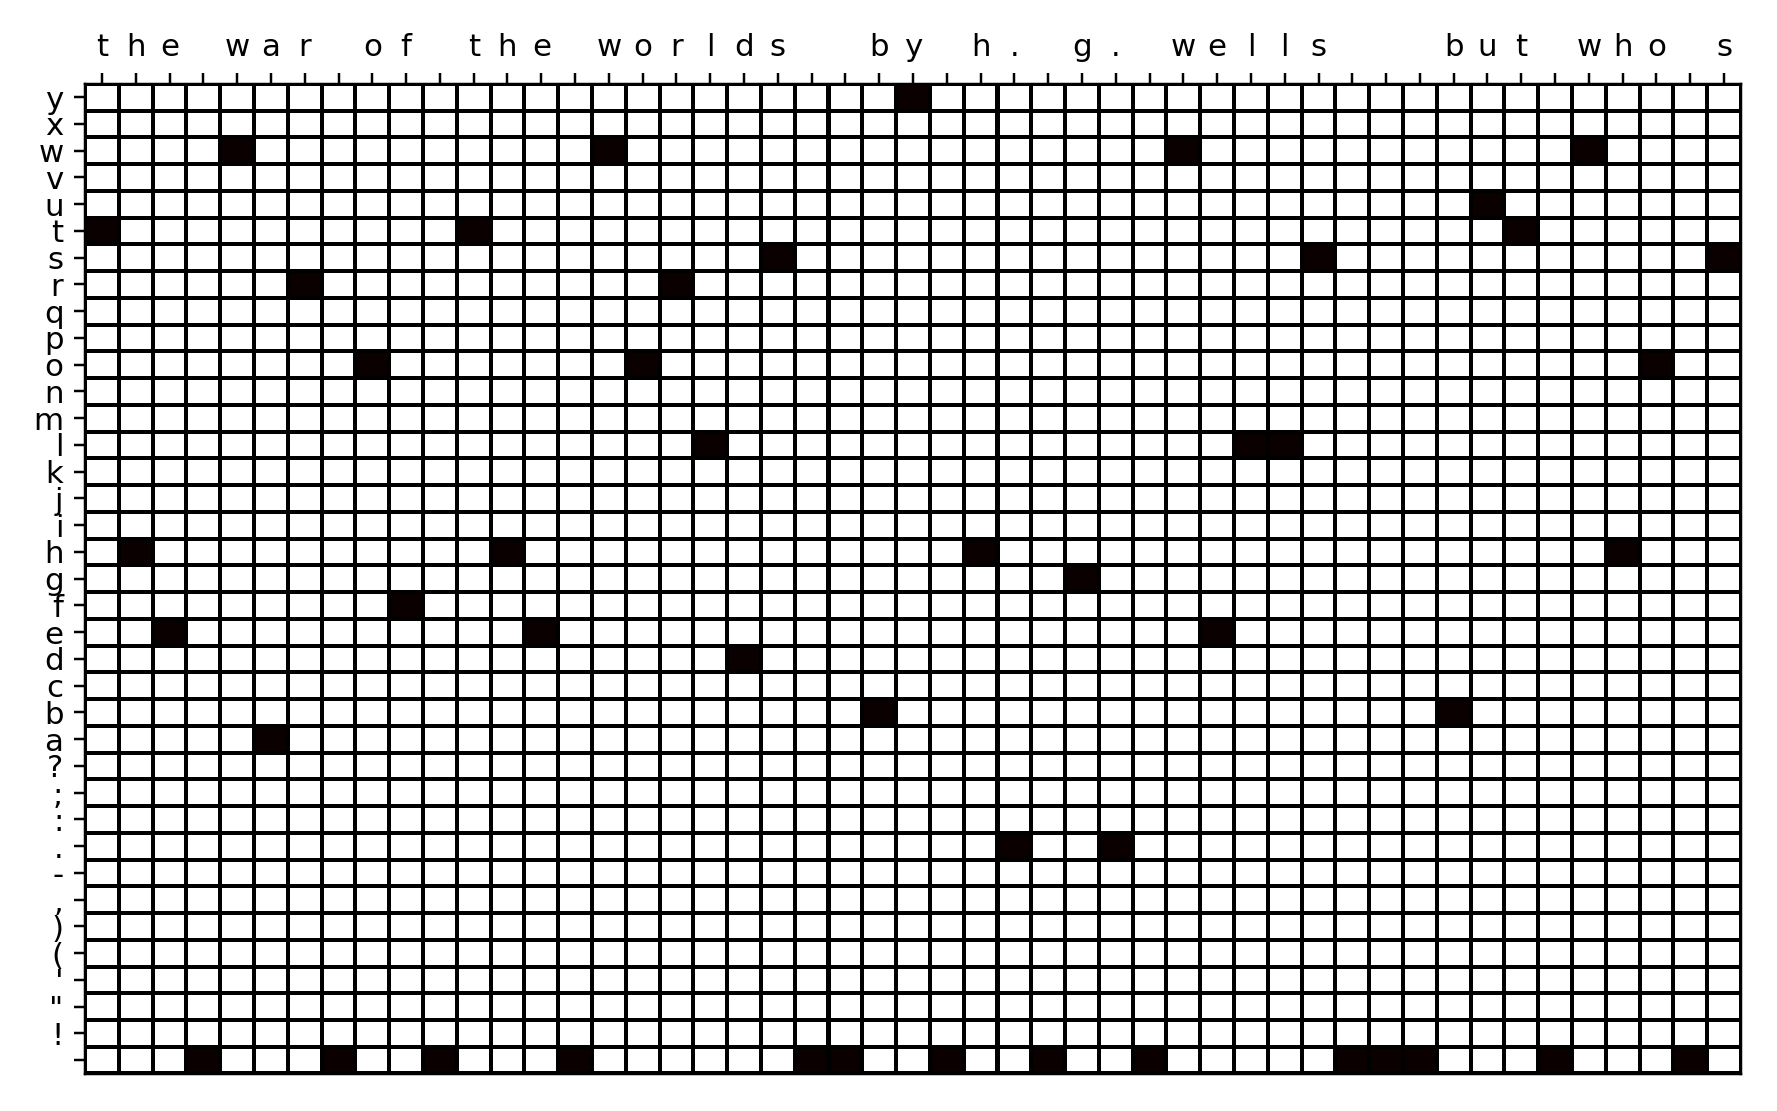

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# show one-hot encoded characters from test corpus
show_series(x_sample,chars)

If we *one-hot encode* characters (or words) we can pull apart we can pull apart the Markov update formula in Equation (6) quite nicely.  First, note that in order to compute a normalized histogram we can simply compute the average of $D$ consecutive characters.  If we call $\mathbf{x}_p$ the one-hot encoded version of the character $x_p$, then we can express a normalized histogram as

\begin{equation}
\mathbf{z}_p = \frac{\mathbf{x}_{p-1}+\mathbf{x}_{p-2} +\,...\,+\mathbf{x}_{p-D}}{D}.
\end{equation}

This we can classify as a standard [moving average process](https://blog.dgsix.com/posts/moving_averages/Moving_averages.html).  To select the next most probable word we then determine the index of the *largest* value from this average - which we can express as

\begin{equation}
h_p = \underset{j}{\text{argmax}}\,\, \left(\mathbf{z}_p\right)
\end{equation}

where here the $\text{argmax}$ returns $h_p$ the index of the largest entry of the histogram $\mathbf{z}_p$ (we can also one-hot encode the index $h_p$ as $\mathbf{h}_p$, a standard basis vector with a $1$ at $h_p$ and $0$ everywhere else so that we only deal with one-hot encoded vectors.  In any case, all together then 

\begin{equation}
\,\,\,  \,\,\,  \,\,\, \,\,\,\,  \,\,\,\,\, \,\,\,  \mathbf{z}_p = \frac{\mathbf{x}_{p-1}+\mathbf{x}_{p-2} +\,...\,+\mathbf{x}_{p-D}}{D}\\
h_p = \underset{j}{\text{argmax}}\,\, \left(\mathbf{z}_p\right).
\end{equation}

we can see that - in terms of basic components - a Markov chain is just a simple tweak on a standard moving average process 



<a id='unlimited'></a>
## Markov chains with unlimited memory

If we were to replace the moving average process component above $\mathbf{z}_p = \frac{\mathbf{x}_{p-1},\,\mathbf{x}_{p-2},\,...,\,\mathbf{x}_{p-D}}{D}$ with a [dynamic system with unlimited memory](https://blog.dgsix.com/posts/dynamic_systems_unlimited_memory/dynamic_systems_unlimited_memory.html) like the simple [exponential average](https://blog.dgsix.com/posts/dynamic_systems_unlimited_memory/dynamic_systems_unlimited_memory.html#examples) $\mathbf{z}_p = \alpha\mathbf{z}_{p-1} + \left(1 - \alpha\right)\mathbf{x}_p$ (where $0 \leq \alpha \leq 1$ we an analogous kind of Markov chain with "unlimited memory"


\begin{equation}
\,\,\,  \,\,\,  \,\,\,   \mathbf{z}_p = \alpha  \mathbf{z}_{p-1} + \left(1 - \alpha\right)\mathbf{x}_p \\
h_p = \underset{j}{\text{argmax}}\,\, \left(\mathbf{z}_p\right).
\end{equation}


Such a Markov chain - technically speaking - makes predictions about future characters based on the entire history of input characters of a text.  

When $\alpha$ is set to smaller values the exponential average looks more and more like the most recent character $\mathbf{x}_p$ (and more similar to an order $D = 1$ limited memory dynamic system).  As $\alpha$ is increased a greater amount historical context is wrapped up into the summarizing variable $\mathbf{z}_p$.  Below we plot the exponential average $\mathbf{z}_p$ of the same set of one-hot encoded characters from our test corpus above.  Here we can see how the exponential average with $\alpha = 0.8$ smears out the content of this first bit of text as it progresses, dragging along historical context.

<IPython.core.display.Javascript object>


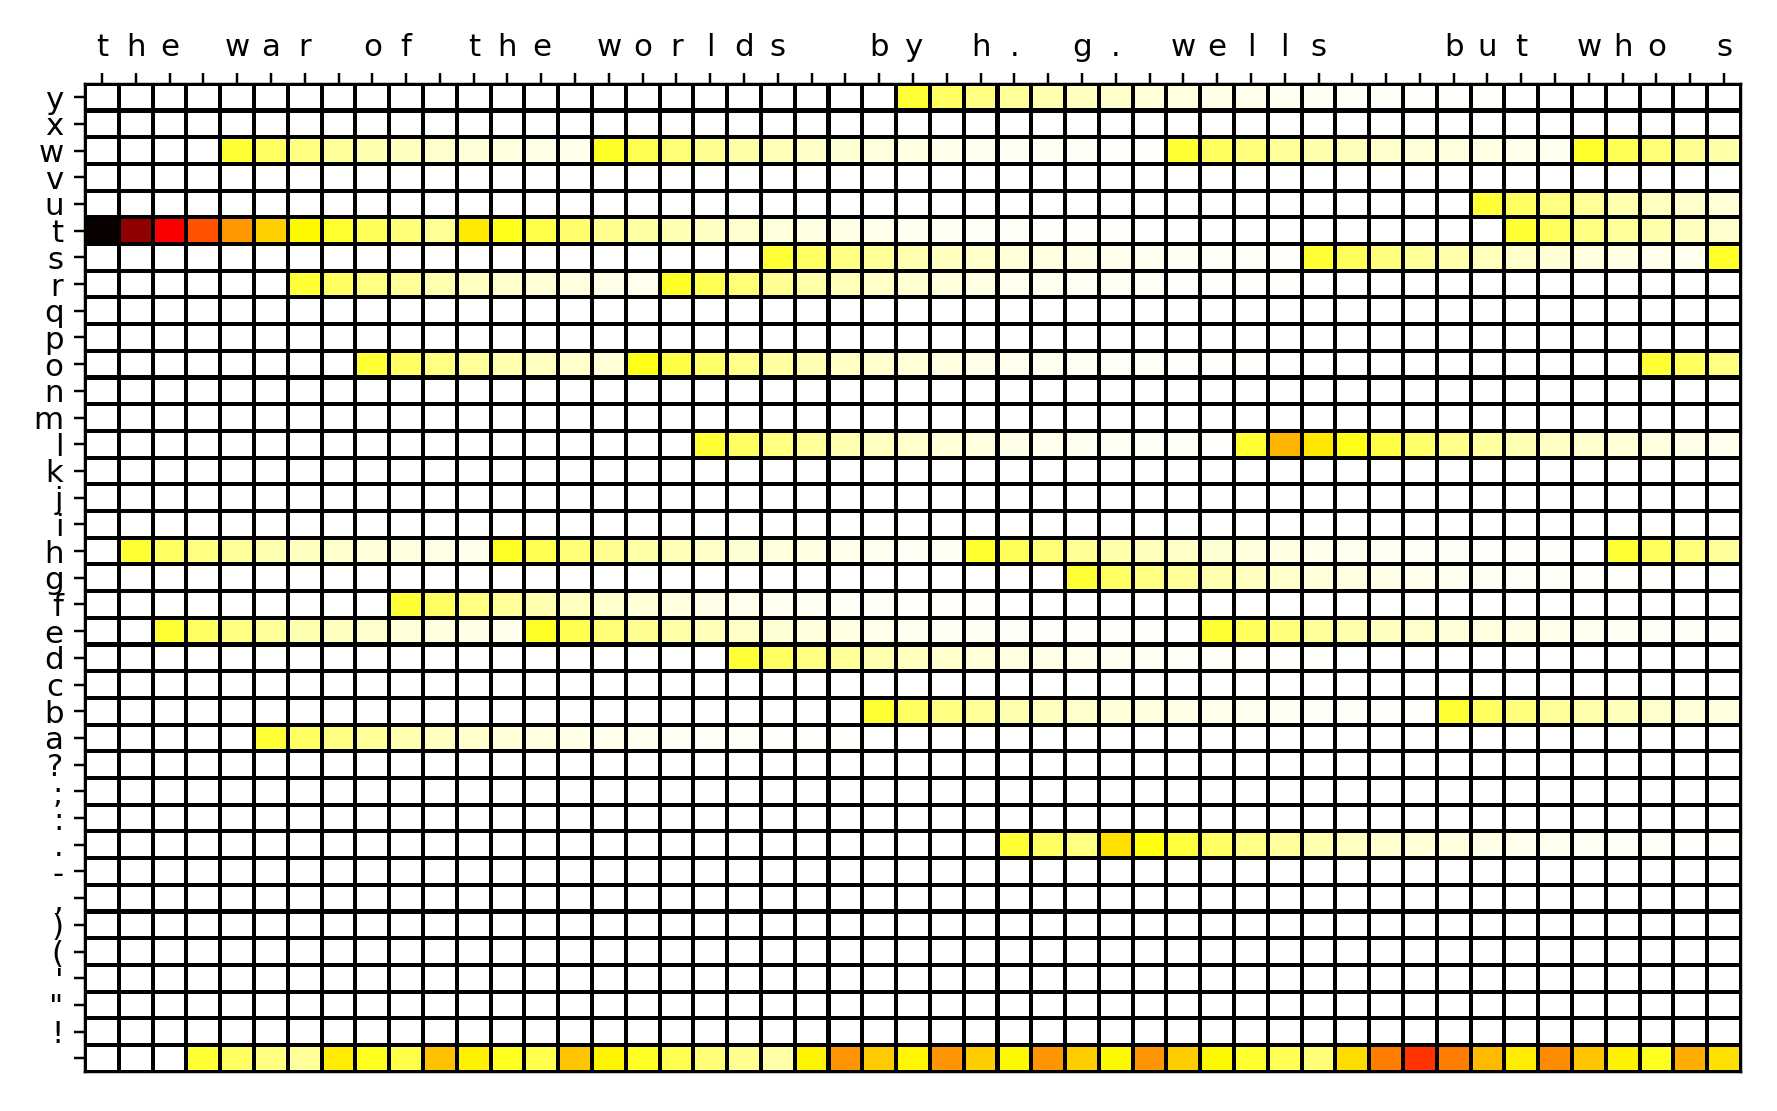

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# running mean
def running_mean(x,alpha):
    # set initial conditions of h to values of x
    h = [x[:,0]]
    
    # range over x and create h
    for p in range(1,np.shape(x)[1]):
        # get current point and prior hidden state
        h_p_prev = h[-1]
        x_p = x[:,p]
    
        # make next element and store
        h_p = alpha*h_p_prev + (1 - alpha)*x_p
        h.append(h_p)
    return np.array(h).T

h = running_mean(x_sample,alpha = 0.8)
show_series(h,chars)